In [45]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import math

# import shapefile
# from shapely.geometry import Polygon
# from descartes.patch import PolygonPatch
from data_utils import filter_outliers
from data_utils import create_ST_map
from data_utils import _data_loader
from sklearn.cluster import KMeans

In [46]:
os.chdir(r'D:\Projects\MobilityForecast\Repo\mobilityforecast\data')

# For Yuri's computer:
# os.chdir('..')
# os.chdir('data')

In [ ]:
# os.chdir(r'D:\Projects\MobilityForecast\Repo\mobilityforecast\data')

# For Yuri's computer:
os.chdir('..')
os.chdir('data')

In [ ]:
## Read the data -> Sort by time -> filter out the data (irrleavant) -> ST feature map -> 
## ST map should capture the demand b/w pick up zone and drop off zone as a function of time(hourly)

## The idea is for the Variantional Auto encoder to predict the t+1 ST map given 1,2,3..,t-1,t ST map

## The processing of the citi bike and the weather data should also follow the same format..

In [ ]:
## The ST map should be a 3D tensor of size (n_pickup_zones, n_dropoff_zones, n_time_steps)
st_map = create_ST_map(data_path='yellow_tripdata_2022-01.parquet', data_type='Taxi', year=2022, month=1, plotting='True')

In [ ]:
train, val, test = _data_loader(st_map, val_size=0.15, test_size=0.15)

print(train.shape, val.shape, test.shape)

In [ ]:
df = pd.read_parquet('yellow_tripdata_2022-01.parquet',engine='pyarrow')
# sorting the values is important to capture the temporal relation of the Spatio temporal data
df = df.sort_values(by='tpep_pickup_datetime', ascending=True)

In [ ]:
df['tpep_pickup_datetime']=pd.to_datetime(df['tpep_pickup_datetime']) # converting the date-time to python date-time objects to access built-in methods
df['tpep_dropoff_datetime']=pd.to_datetime(df['tpep_dropoff_datetime'])

In [ ]:
df = df.drop(columns=['store_and_fwd_flag', 'VendorID' , 'RatecodeID', 'payment_type','fare_amount', 'extra' , 'mta_tax', 'tip_amount',
'tolls_amount', 'improvement_surcharge','total_amount', 'congestion_surcharge', 'airport_fee', 'trip_distance', 'passenger_count']) # dropping the store and forward flag, VendorID is the company that provided the record(this does not add any value to our study)
df = df.dropna(axis=0) # RatecodeID and payment_type are categorical features affecting the price of the trip, we discard this for the moment as this does not add value to our study. 
df.head(5)

In [ ]:
# splitting the date-time objects to date and time

df['pickup_year'] = df['tpep_pickup_datetime'].apply(lambda t: t.year)
df['pickup_month'] = df['tpep_pickup_datetime'].apply(lambda t: t.month)
df['pickup_weekday'] = df['tpep_pickup_datetime'].apply(lambda t: t.day)
df['pickup_hour'] = df['tpep_pickup_datetime'].apply(lambda t: t.hour)

df = df.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

In [ ]:
# filter out the dates which are irrelavnt to the study

df = df[(df.pickup_year == 2022)]
df = df[(df.pickup_month == 1)]

In [ ]:
#df = df.drop(columns=['dropoff_year', 'dropoff_month','dropoff_weekday','dropoff_hour', 'pickup_year', 'pickup_month'])
df = df.drop(columns=['pickup_year', 'pickup_month'])
df.head()

In [ ]:
features = df.pivot_table(columns=["PULocationID", "DOLocationID","pickup_weekday", "pickup_hour"], aggfunc='size').reset_index(name='demand')
features = pd.DataFrame(features).reset_index(drop=True)
features

In [ ]:
rows = 265+1
cols = 265+1

days = np.unique(features.pickup_weekday)
hours = np.unique(features.pickup_hour)

In [ ]:
features_days = []
features_hours = []
features_days = [features[features.pickup_weekday == i] for i in days]
for i in range(0,len(features_days)):
    for j in hours:
        features_hours.append(features_days[i][features_days[i].pickup_hour == j])

In [ ]:
ST_map = np.zeros((rows,cols, len(features_hours)))

In [ ]:
for i in range(0,len(features_hours)):
    features_hours[i] = features_hours[i].drop(columns=["pickup_weekday","pickup_hour"])
    rind = np.array(features_hours[i].PULocationID.array)
    cind = np.array(features_hours[i].DOLocationID.array)
    demand = np.array(features_hours[i].demand.array)
    ST_map[rind,cind,i] = demand
ST_map = ST_map[1::,1::,:]

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))
sns.heatmap(ST_map[:,:,0], ax=ax1)
sns.heatmap(ST_map[:,:,17], ax=ax2)

# Heading

In [47]:
df = pd.read_csv('202201-citibike-tripdata.csv',low_memory=False)

In [48]:
df.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual'],
      dtype='object')

In [49]:
#df = df.drop(columns=['ride_id', 'rideable_type', 'start_station_name', 'start_station_id', 'end_station_name', 'end_station_id', 'member_casual'])
df.head(10)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,55262E4365A955A2,classic_bike,2022-01-18 08:23:52,2022-01-18 08:28:18,Boerum Pl\t& Pacific St,4488.09,Clinton St & Joralemon St,4605.04,40.688489,-73.991160,40.692395,-73.993379,member
1,D272F1B15D841EC0,classic_bike,2022-01-21 09:03:22,2022-01-21 09:05:44,E 12 St & Ave C,5616.08,E 10 St & Avenue A,5659.05,40.727243,-73.976831,40.727408,-73.981420,member
2,D1FCEF55EB4A807F,classic_bike,2022-01-22 14:28:32,2022-01-22 14:53:18,W 21 St & 6 Ave,6140.05,W 44 St & 11 Ave,6756.05,40.741740,-73.994156,40.762009,-73.996975,member
3,E9CBDC6A0162C068,electric_bike,2022-01-19 14:49:47,2022-01-19 14:54:02,38 St & 30 Ave,6850.01,Crescent St & 30 Ave,6958.06,40.764175,-73.915840,40.768692,-73.924957,member
4,2177A5B57326CE9B,electric_bike,2022-01-16 14:36:06,2022-01-16 14:44:06,Pacific St & Nevins St,4362.04,Clinton St & Tillary St,4748.07,40.685376,-73.983021,40.696233,-73.991421,member
5,86070FD23B40E3B8,electric_bike,2022-01-28 23:20:01,2022-01-28 23:32:18,11 Ave & W 41 St,6726.01,E 40 St & 5 Ave,6474.11,40.760301,-73.998842,40.752062,-73.981632,member
6,5E4425CCF4C92012,electric_bike,2022-01-28 17:12:46,2022-01-28 17:27:03,Kosciuszko St & Nostrand Ave,4519.04,Eastern Pkwy & Washington Ave,3928.08,40.690725,-73.951335,40.671649,-73.963115,member
7,B10B3DB76684E8F4,classic_bike,2022-01-04 22:12:48,2022-01-04 22:18:27,W 21 St & 6 Ave,6140.05,E 20 St & 2 Ave,5971.08,40.741740,-73.994156,40.735877,-73.982050,member
8,9C15288CA17FC5AC,classic_bike,2022-01-08 11:34:22,2022-01-08 11:43:14,Carmine St & 6 Ave,5763.03,Howard St & Lafayette St,5422.04,40.730386,-74.002150,40.719105,-73.999733,member
9,74247CBD0BCFD89B,electric_bike,2022-01-26 19:04:18,2022-01-26 19:09:05,W 21 St & 6 Ave,6140.05,W 31 St & 7 Ave,6331.01,40.741740,-73.994156,40.749156,-73.991600,member


In [44]:
# os.chdir(r'D:\Projects\MobilityForecast\Repo\mobilityforecast\help\images')
# img1 = plt.imread('nyc_-74.3_-73.7_40.5_40.9.png')
# img2 = plt.imread('nyc_-74.5_-72.8_40.5_41.8.png')

In [ ]:
def kmeans_grid(lat, lon, num_clusters):
    x = np.array([lat, lon]).T
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    label = kmeans.fit_predict(x)
    centroids = kmeans.cluster_centers_
    u_labels = np.unique(label)
    for i in u_labels:
        plt.scatter(x[label == i , 0] , x[label == i , 1] , label = i)
    plt.scatter(centroids[:,0] , centroids[:,1] , s = 15, color = 'k')
    plt.legend()
    plt.show()
pass

In [ ]:
kmeans_grid(df.start_lat, df.start_lng, 10)

In [7]:
regions = 4

start_lat_min, start_lat_max = df.start_lat.agg(['min','max'])
start_lng_min, start_lng_max = df.start_lng.agg(['min','max'])

end_lat_min, end_lat_max = df.end_lat.agg(['min','max'])
end_lng_min, end_lng_max = df.end_lng.agg(['min','max'])

west = min(start_lat_min, end_lat_min)
east = max(start_lat_max, end_lat_max)

south = min(start_lng_min, end_lng_min)
north = max(start_lng_max, end_lng_max)

lat_bins = np.linspace(west,east,regions)
lng_bins = np.linspace(south, north, regions)

bins = np.stack(np.meshgrid(lat_bins, lng_bins)).T.reshape(-1,2)

In [14]:
names = list(map(int, range(regions)))

cord_bins = np.array(np.meshgrid(np.arange(regions), np.arange(regions))).T.reshape(-1,2)
cord_bins = list(map(tuple, cord_bins))

In [15]:
df['start_lat_regions']=pd.cut(df['start_lat'], bins=regions,labels = names, retbins=False, right=True, include_lowest=True)
df['start_lng_regions']=pd.cut(df['start_lng'], bins=regions,labels= names, retbins=False, right=True, include_lowest=True)

df['end_lat_regions']=pd.cut(df['end_lat'], bins=regions,labels = names, retbins=False, right=True, include_lowest=True)
df['end_lng_regions']=pd.cut(df['end_lng'], bins=regions,labels= names, retbins=False, right=True, include_lowest=True)

In [16]:
#tmp = np.array([*list(zip(df.lat_regions, df.lng_regions))])
df['PU_region'] =list(zip(df.start_lat_regions, df.start_lng_regions)) #np.array([*tmp]).tolist()
df['DO_region'] =list(zip(df.end_lat_regions, df.end_lng_regions))

In [17]:
df = df.drop(columns=['start_lat_regions','start_lng_regions','end_lat_regions','end_lng_regions'])
df.head(5)

,started_at,ended_at,start_lat,start_lng,end_lat,end_lng,PU_region,DO_region
0,2022-01-18 08:23:52,2022-01-18 08:28:18,40.688489,-73.991160,40.692395,-73.993379,"(0, 0)","(0, 1)"
1,2022-01-21 09:03:22,2022-01-21 09:05:44,40.727243,-73.976831,40.727408,-73.981420,"(1, 1)","(1, 1)"
2,2022-01-22 14:28:32,2022-01-22 14:53:18,40.741740,-73.994156,40.762009,-73.996975,"(1, 0)","(2, 1)"
3,2022-01-19 14:49:47,2022-01-19 14:54:02,40.764175,-73.915840,40.768692,-73.924957,"(2, 3)","(2, 2)"
4,2022-01-16 14:36:06,2022-01-16 14:44:06,40.685376,-73.983021,40.696233,-73.991421,"(0, 1)","(1, 1)"


In [18]:
for i in range(0,len(cord_bins)):
    df.loc[df['PU_region'] == cord_bins[i], 'PU_region'] = i+1
    df.loc[df['DO_region'] == cord_bins[i], 'DO_region'] = i+1

In [19]:
df.head()

,started_at,ended_at,start_lat,start_lng,end_lat,end_lng,PU_region,DO_region
0,2022-01-18 08:23:52,2022-01-18 08:28:18,40.688489,-73.991160,40.692395,-73.993379,1,2
1,2022-01-21 09:03:22,2022-01-21 09:05:44,40.727243,-73.976831,40.727408,-73.981420,6,6
2,2022-01-22 14:28:32,2022-01-22 14:53:18,40.741740,-73.994156,40.762009,-73.996975,5,10
3,2022-01-19 14:49:47,2022-01-19 14:54:02,40.764175,-73.915840,40.768692,-73.924957,12,11
4,2022-01-16 14:36:06,2022-01-16 14:44:06,40.685376,-73.983021,40.696233,-73.991421,2,6


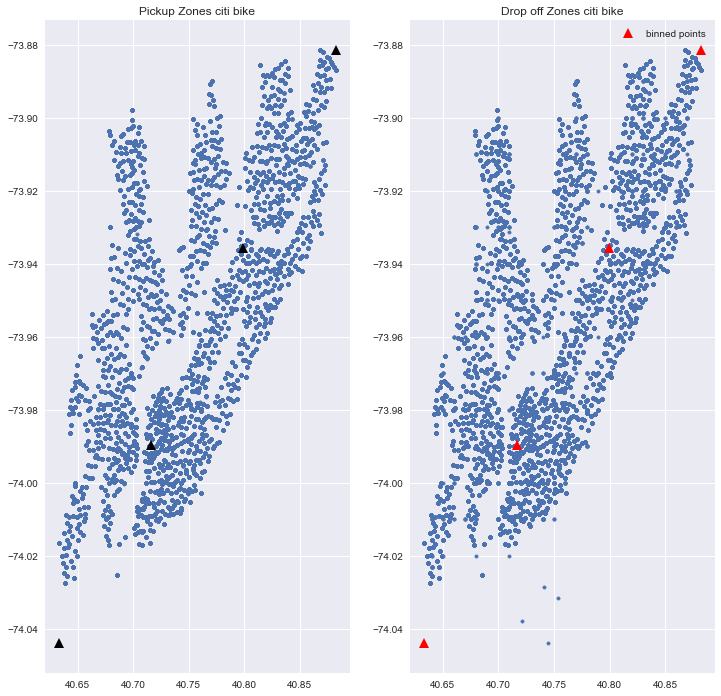

In [42]:
from numpy import size


plt.style.use('seaborn')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,12))
ax1.scatter(df.start_lat,df.start_lng, marker='.')
ax1.plot(lat_bins,lng_bins, 'k^', markersize=10, label='binned points')
ax2.scatter(df.end_lat,df.end_lng, marker='.')
ax2.plot(lat_bins,lng_bins, 'r^', markersize=10, label='binned points')
ax1.set_title('Pickup Zones citi bike')
ax2.set_title('Drop off Zones citi bike')
plt.legend(loc="best")
plt.show()
